### Markowitz Portfolio Optimization
#### Monte-Carlo Approach

In [1]:
# calculations
import pandas as pd
import numpy as np

# plotting 
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# data
import yfinance as yf

from tqdm import tqdm

# Portfolio Solver
import cvxpy as cp

#  import cvxopt as cp
from cvxopt import matrix, solvers

In [34]:
# import data
daily_returns = yf.download(["P3K.F","SNH.F","M5Z.DE","WAH.DE","XTP.WA","T5O.F","EXL.DE"], period= "2y", interval="1d")
dr = daily_returns["Adj Close"].pct_change()

[*********************100%***********************]  7 of 7 completed


In [35]:
p3k = yf.Ticker("P3K.F")
p3k.financials

,2021-06-30,2020-06-30,2019-06-30,2018-06-30
Research Development,None,None,None,None
Effect Of Accounting Charges,None,None,None,None
Income Before Tax,-8241166.0,-3773988.0,45532845.0,-8753604.0
Minority Interest,NaN,NaN,-54708.0,-54708.0
Net Income,-6722487.0,-16978595.0,35507082.0,-8753604.0
Selling General Administrative,5034361.0,3667635.0,5182969.0,1922917.0
Gross Profit,0.0,0.0,-218077.0,201801.0
Ebit,-8245399.0,-3797747.0,-53056036.0,-8760462.0
Operating Income,-8245399.0,-3797747.0,-53056036.0,-8760462.0
Other Operating Expenses,None,None,None,None


In [36]:
# annulized retruns
mus = (1+dr.mean())**252 - 1 

# convariance
covar = dr.cov()*252
covar


,EXL.DE,M5Z.DE,P3K.F,SNH.F,T5O.F,WAH.DE,XTP.WA
EXL.DE,0.330893,0.091619,0.027005,0.103626,0.026641,0.017292,0.011013
M5Z.DE,0.091619,0.367856,0.046270,0.054705,0.032169,0.029492,0.029851
P3K.F,0.027005,0.046270,1.061422,0.083831,0.020502,-0.006945,0.040181
SNH.F,0.103626,0.054705,0.083831,0.952783,0.022474,0.006039,-0.004069
T5O.F,0.026641,0.032169,0.020502,0.022474,0.388536,0.008179,0.003818
WAH.DE,0.017292,0.029492,-0.006945,0.006039,0.008179,0.184833,0.012164
XTP.WA,0.011013,0.029851,0.040181,-0.004069,0.003818,0.012164,0.395397


In [37]:
n_assets = 5
n_portfolios = 1000

mean_variance_pairs = []

np.random.seed(1993)

for i in range(n_portfolios):
    assets = np.random.choice(list(dr.columns), n_assets, replace = False)
    weights = np.random.rand(n_assets)
    weights = weights/sum(weights)

    portfolio_E_retruns = 0
    portfolio_E_variance = 0

    for i in range(len(assets)):
        portfolio_E_retruns += weights[i] * mus.loc[assets[i]]

        for j in range(len(assets)):
            portfolio_E_variance += weights[i] * weights[j] * covar.loc[assets[i],assets[j]]

    mean_variance_pairs.append([portfolio_E_retruns,portfolio_E_variance])

In [38]:
# mean_variance_pairs

In [39]:
# Plotting
mean_variance_pairs = np.array(mean_variance_pairs)

risk_free_rate=0 #-- Include risk free rate here

fig = go.Figure()
fig.add_trace(go.Scatter(x=mean_variance_pairs[:,1]**0.5, y=mean_variance_pairs[:,0], 
                      marker=dict(color=(mean_variance_pairs[:,0]-risk_free_rate)/(mean_variance_pairs[:,1]**0.5), 
                                  showscale=True, 
                                  size=7,
                                  line=dict(width=1),
                                  colorscale="RdBu",
                                  colorbar=dict(title="Sharpe<br>Ratio")
                                 ), 
                      mode='markers'))
fig.update_layout(template='plotly_white',
                  xaxis=dict(title='Annualised Risk (Volatility)'),
                  yaxis=dict(title='Annualised Return'),
                  title='Sample of Random Portfolios',
                  width=850,
                  height=500)
fig.update_xaxes(range=[0.18, 0.32])
fig.update_yaxes(range=[0.02,0.27])
fig.update_layout(coloraxis_colorbar=dict(title="Sharpe Ratio"))

In [40]:
n_assets = 5

mean_variance_pairs = []
weights_list=[]
tickers_list=[]

for i in tqdm(range(10000)):
    next_i = False
    while True:
        #- Choose assets randomly without replacement
        assets = np.random.choice(list(dr.columns), n_assets, replace=False)
        #- Choose weights randomly ensuring they sum to one
        weights = np.random.rand(n_assets)
        weights = weights/sum(weights)

        #-- Loop over asset pairs and compute portfolio return and variance
        portfolio_E_Variance = 0
        portfolio_E_Return = 0
        for i in range(len(assets)):
            portfolio_E_Return += weights[i] * mus.loc[assets[i]]
            for j in range(len(assets)):
                portfolio_E_Variance += weights[i] * weights[j] * covar.loc[assets[i], assets[j]]

        #-- Skip over dominated portfolios
        for R,V in mean_variance_pairs:
            if (R > portfolio_E_Return) & (V < portfolio_E_Variance):
                next_i = True
                break
        if next_i:
            break

        #-- Add the mean/variance pairs to a list for plotting
        mean_variance_pairs.append([portfolio_E_Return, portfolio_E_Variance])
        weights_list.append(weights)
        tickers_list.append(assets)
        break

100%|██████████| 10000/10000 [00:02<00:00, 3758.76it/s]


In [50]:
mean_variance_pairs = np.array(mean_variance_pairs)

risk_free_rate=0 #-- Include risk free rate here

fig = go.Figure()
fig.add_trace(go.Scatter(x=mean_variance_pairs[:,1]**0.5, y=mean_variance_pairs[:,0], 
                      marker=dict(color=(mean_variance_pairs[:,0]-risk_free_rate)/(mean_variance_pairs[:,1]**0.5), 
                                  showscale=True, 
                                  size=7,
                                  line=dict(width=1),
                                  colorscale="RdBu",
                                  colorbar=dict(title="Sharpe<br>Ratio")
                                 ), 
                      mode='markers',
                      text=[str(np.array(tickers_list[i])) + "<br>" + str(np.array(weights_list[i]).round(2)) for i in range(len(tickers_list))]))
fig.update_layout(template='plotly_white',
                  xaxis=dict(title='Annualised Risk (Volatility)'),
                  yaxis=dict(title='Annualised Return'),
                  title='Sample Portfilo',
                  width=850,
                  height=500)
fig.update_xaxes(range=[0.2, 1])
fig.update_yaxes(range=[0.0,4])
fig.update_layout(coloraxis_colorbar=dict(title="Sharpe Ratio"))

#### Temperature Targeting Program
$$ 
max \left( x' \mu - \frac{RA}{2} x' \sum x \right)  \\
s.t. \; x'T \leq \bar{T} \\
\; \; x \geq 0 \\
\\
x' \mu \;: \; \text{Expected Return} \\
\frac{RA}{2} x' \sum x \; : \; \text{Risk aversion} \\
\bar{T} \; : \; 

$$

#### TA Utility 
$$
max \left( x' \mu - \frac{RA}{2} x' \sum x - \; TA \; x'T \right)  \\
s.t. \; x \geq 0
$$

In [13]:
Sigma = covar.to_numpy()
Sigma

array([[ 0.33089293,  0.09161864,  0.02572917,  0.10362618,  0.02666516,
         0.01729193,  0.01101297],
       [ 0.09161864,  0.28387374,  0.05054269,  0.07409793,  0.03120352,
         0.03429168,  0.02230768],
       [ 0.02572917,  0.05054269,  0.91094181,  0.09763219,  0.01496154,
        -0.00331545,  0.01044742],
       [ 0.10362618,  0.07409793,  0.09763219,  1.13002474,  0.01789955,
         0.03083408,  0.00236551],
       [ 0.02666516,  0.03120352,  0.01496154,  0.01789955,  0.47866099,
         0.00964412,  0.01613045],
       [ 0.01729193,  0.03429168, -0.00331545,  0.03083408,  0.00964412,
         0.24219601,  0.01889339],
       [ 0.01101297,  0.02230768,  0.01044742,  0.00236551,  0.01613045,
         0.01889339,  0.44241258]])

In [14]:
n = Sigma.shape[0]

In [15]:
# mu = dr.mean().values
# mu

In [16]:
mu =  np.array(mus)
mu


array([-0.24870141,  0.16123977,  1.73102865, -0.04378517, -0.01142262,
        0.43265374,  0.24713404])

In [17]:
asset_vols = np.sqrt(Sigma.diagonal())
asset_vols

array([0.57523294, 0.53279803, 0.95443272, 1.06302622, 0.6918533 ,
       0.49213414, 0.66514102])

In [18]:
w = cp.Variable(n)
w

Variable((7,))

In [19]:
ret = mu.T @ w
ret

Expression(AFFINE, UNKNOWN, ())

In [20]:
vol = cp.quad_form(w, Sigma)

In [21]:
vol

Expression(CONVEX, NONNEGATIVE, (1, 1))

In [22]:
prob = cp.Problem(cp.Minimize(vol),  
                  [cp.sum(w) == 1,   
                   w >= 0]           
                 )

In [23]:
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]
minvol = vol.value
minvol

0.08258469001508462

In [24]:
prob = cp.Problem(cp.Maximize(ret),  
                  [cp.sum(w) == 1, 
                   w >= 0]
                )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]
maxretvol = vol.value
maxretvol

0.9109418090977931

In [25]:
vol_limit = cp.Parameter(nonneg=True)

prob = cp.Problem(cp.Maximize(ret),
                  [cp.sum(w) == 1, 
                   w >= 0,
                   vol <= vol_limit  
                  ]
                 )

# define helper function 
def solve_vl(vl_val):
    vol_limit.value = vl_val
    result = prob.solve()
    return (ret.value, np.sqrt(vol.value), w.value)

# number of points on the frontier
NPOINTS = 200
vl_vals = np.linspace(minvol, maxretvol, NPOINTS)

# iterate over vl_vals
results_dict = {}
for vl_val in vl_vals:
    results_dict[vl_val] = solve_vl(vl_val)

minvol, maxretvol


C:\Users\benja\.conda\envs\mlcourse\lib\site-packages\cvxpy\problems\problem.py:1333: UserWarning:

Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.



(0.08258469001508462, 0.9109418090977931)

In [26]:
list(results_dict)

[0.08258469001508462,
 0.08674728860343994,
 0.09090988719179526,
 0.09507248578015057,
 0.0992350843685059,
 0.10339768295686122,
 0.10756028154521653,
 0.11172288013357184,
 0.11588547872192717,
 0.1200480773102825,
 0.12421067589863781,
 0.12837327448699312,
 0.13253587307534845,
 0.13669847166370377,
 0.14086107025205907,
 0.1450236688404144,
 0.14918626742876973,
 0.15334886601712505,
 0.15751146460548038,
 0.16167406319383568,
 0.165836661782191,
 0.16999926037054633,
 0.17416185895890163,
 0.17832445754725695,
 0.18248705613561228,
 0.1866496547239676,
 0.19081225331232293,
 0.19497485190067823,
 0.19913745048903356,
 0.20330004907738888,
 0.20746264766574418,
 0.2116252462540995,
 0.21578784484245483,
 0.21995044343081016,
 0.2241130420191655,
 0.22827564060752079,
 0.2324382391958761,
 0.23660083778423144,
 0.24076343637258674,
 0.24492603496094206,
 0.2490886335492974,
 0.2532512321376527,
 0.25741383072600804,
 0.2615764293143633,
 0.26573902790271864,
 0.26990162649107396,


In [27]:
vola = []
returns = []
for i in list(results_dict):
    vola.append(results_dict[i][1])
    returns.append(results_dict[i][0])

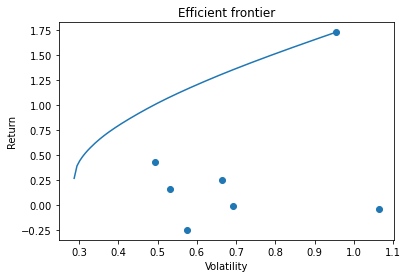

In [28]:
plt.plot(vola,returns)    
plt.scatter(asset_vols,mu)
plt.title("Efficient frontier")
plt.xlabel("Volatility")
plt.ylabel("Return");

In [29]:
mus

EXL.DE   -0.248701
M5Z.DE    0.161240
P3K.F     1.731029
SNH.F    -0.043785
T5O.F    -0.011423
WAH.DE    0.432654
XTP.WA    0.247134
dtype: float64

In [30]:
asset_vols

array([0.57523294, 0.53279803, 0.95443272, 1.06302622, 0.6918533 ,
       0.49213414, 0.66514102])

In [29]:
correl = np.array([[1,0,0.75,0.48,0.75,0.48],[0,1,0.06,0.06,0.06,0.06],
        [0.75,0.06,1,0.36,0.63,0.36],[0.48,0.06,0.36,1,0.36,0.6],
        [0.75,0.06,0.63,0.36,1,0.36],[0.48,0.06,0.36,0.6,0.36,1]])

In [30]:
correl

array([[1.  , 0.  , 0.75, 0.48, 0.75, 0.48],
       [0.  , 1.  , 0.06, 0.06, 0.06, 0.06],
       [0.75, 0.06, 1.  , 0.36, 0.63, 0.36],
       [0.48, 0.06, 0.36, 1.  , 0.36, 0.6 ],
       [0.75, 0.06, 0.63, 0.36, 1.  , 0.36],
       [0.48, 0.06, 0.36, 0.6 , 0.36, 1.  ]])

In [31]:
np.cov(correl,rowvar=)

SyntaxError: invalid syntax (<ipython-input-31-1e40ca9bd55d>, line 1)

#### First-Stage Markowitz Mean Variance Portfolio Optimization
$$ 
max \left( x' \mu - \frac{RA}{2} x' \sum x \right)  \\
\;s.t. \; x \geq 0 \\

$$

##### Revealed Preferences
$$
\bar{R}_{RA} = \bar{x}_{RA}' \mu \\
\bar{V}_{RA} = \sqrt{\bar{x}_{RA} ' \sum \bar{x}_{RA}} \\ 
\bar{U}_{RA} = \bar{R}_{RA} - \frac{RA}{2}\bar{V}_{RA}

$$

#### Second-Stage Maximum Impact Optimization
##### Risk and retrun preservation
$$
max (x'I_{Impact}) \\
s.t. \; \; x'\mu = \bar{R}_{RA} \\
\sqrt{\bar{x} ' \sum \bar{x}} = \bar{V}_{RA}  \\ 
$$
##### Utility preservation
$$
max (x'I_{Impact}) \\
s.t. \; \; x'\mu - \frac{RA}{2} x' \sum x = \bar{U}_{RA} \\


$$

In [32]:
correl_Imp = np.array([[1,0,0.75,0.48,0.75,0.48],[0,1,0.06,0.06,0.06,0.06],
        [0.75,0.06,1,0.36,0.63,0.36],[0.48,0.06,0.36,1,0.36,0.6],
        [0.75,0.06,0.63,0.36,1,0.36],[0.48,0.06,0.36,0.6,0.36,1]])
vol_lst_Imp = [15,4,20,12.5,20.5,13.5]
correl_Imp, vol_lst_Imp

(array([[1.  , 0.  , 0.75, 0.48, 0.75, 0.48],
        [0.  , 1.  , 0.06, 0.06, 0.06, 0.06],
        [0.75, 0.06, 1.  , 0.36, 0.63, 0.36],
        [0.48, 0.06, 0.36, 1.  , 0.36, 0.6 ],
        [0.75, 0.06, 0.63, 0.36, 1.  , 0.36],
        [0.48, 0.06, 0.36, 0.6 , 0.36, 1.  ]]),
 [15, 4, 20, 12.5, 20.5, 13.5])

Correlation to covariance matrix
$$
cov_{x,y} = r_{x,y} * \sigma_{x} * \sigma{y}
$$

In [33]:
correl = correl_Imp[:4,:4] 
vol_lst = vol_lst_Imp[:4]
correl,vol_lst


(array([[1.  , 0.  , 0.75, 0.48],
        [0.  , 1.  , 0.06, 0.06],
        [0.75, 0.06, 1.  , 0.36],
        [0.48, 0.06, 0.36, 1.  ]]),
 [15, 4, 20, 12.5])

In [34]:
from Functions.Statistics import *

In [36]:
covar = corr_to_cov(correl, vol_lst)
covar

array([[225.  ,   0.  , 225.  ,  90.  ],
       [  0.  ,  16.  ,   4.8 ,   3.  ],
       [225.  ,   4.8 , 400.  ,  90.  ],
       [ 90.  ,   3.  ,  90.  , 156.25]])

In [37]:
n = len(vol_lst)
n

4

In [38]:
mu_Imp = np.array([5.5,2,6,2.5,5.2,3])
mu = mu_Imp[:4]

In [39]:
w = cp.Variable(n)
w

Variable((4,))

In [40]:
ret = mu.T @ w
ret

Expression(AFFINE, UNKNOWN, ())

In [41]:
vol = cp.quad_form(w, covar)
vol

Expression(CONVEX, NONNEGATIVE, (1, 1))

In [42]:
covar = corr_to_cov(correl, vol_lst)
covar

array([[225.  ,   0.  , 225.  ,  90.  ],
       [  0.  ,  16.  ,   4.8 ,   3.  ],
       [225.  ,   4.8 , 400.  ,  90.  ],
       [ 90.  ,   3.  ,  90.  , 156.25]])

In [43]:
prob = cp.Problem(cp.Minimize(vol),  
                  [cp.sum(w) == 1,   
                   w >= 0]           
                 )

In [44]:
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]
minvol = vol.value
minvol

14.627129144777589

In [45]:
prob = cp.Problem(cp.Maximize(ret),  
                  [cp.sum(w) == 1, 
                   w >= 0]
                )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]
maxretvol = vol.value
maxretvol

399.99998308940627

In [46]:
vol_limit = cp.Parameter(nonneg=True)

prob = cp.Problem(cp.Maximize(ret),
                  [cp.sum(w) == 1, 
                   w >= 0,
                   vol <= vol_limit  
                  ]
                 )

# define helper function 
def solve_vl(vl_val):
    vol_limit.value = vl_val
    result = prob.solve()
    return (ret.value, np.sqrt(vol.value), w.value)

# number of points on the frontier
NPOINTS = 200
vl_vals = np.linspace(minvol, maxretvol, NPOINTS)

# iterate over vl_vals
results_dict = {}
for vl_val in vl_vals:
    results_dict[vl_val] = solve_vl(vl_val)

minvol, maxretvol


(14.627129144777589, 399.99998308940627)

In [47]:
vola = []
returns = []
for i in list(results_dict):
    vola.append(results_dict[i][1])
    returns.append(results_dict[i][0])

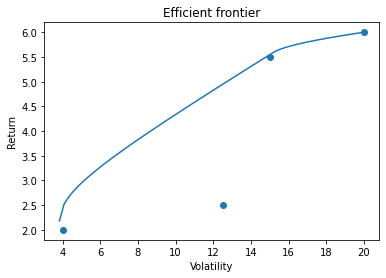

In [48]:
plt.plot(vola,returns)    
plt.scatter(vol_lst,mu)
plt.title("Efficient frontier")
plt.xlabel("Volatility")
plt.ylabel("Return");

In [49]:
volat = list(results_dict)

In [50]:
results_dict[list(results_dict)[0]]

(2.182449521160615,
 3.82454305524845,
 array([4.49323702e-02, 9.04695150e-01, 2.46860332e-08, 5.03724147e-02]))

In [51]:
weights = pd.DataFrame()
for i in list(results_dict):
    # print(pd.DataFrame([results_dict[i][2]]))
    weights = weights.append(pd.DataFrame([results_dict[i][2]]), ignore_index=True)
weights.index = np.sqrt(volat)

In [52]:
weights

,0,1,2,3
3.824543,4.493237e-02,9.046952e-01,2.468603e-08,5.037241e-02
4.069850,1.480484e-01,8.482546e-01,2.520775e-07,3.696822e-03
4.301189,1.861663e-01,8.122474e-01,1.586205e-03,4.443488e-09
4.520705,2.084441e-01,7.835411e-01,8.014872e-03,3.650291e-09
4.730044,2.271563e-01,7.594857e-01,1.335794e-02,1.751946e-09
...,...,...,...,...
19.805398,2.238250e-02,2.400175e-10,9.776175e-01,2.720073e-10
19.854227,1.673912e-02,1.922747e-10,9.832609e-01,2.220168e-10
19.902937,1.112795e-02,1.827580e-10,9.888721e-01,2.071080e-10
19.951527,5.548433e-03,8.299601e-10,9.944516e-01,9.240231e-10


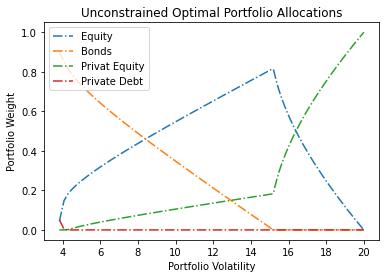

In [53]:
plt.plot(weights, linestyle = "-.")
plt.xlabel("Portfolio Volatility")
plt.ylabel("Portfolio Weight")
plt.legend(["Equity","Bonds","Privat Equity","Private Debt"])
plt.title("Unconstrained Optimal Portfolio Allocations");
# plt.xticks(volat)